In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)
os.chdir(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 8

In [6]:
dataset = get_dataset("cameraman",scale=scale, random_state=1)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(7.5), np.float64(7.5), np.float64(-0.5))

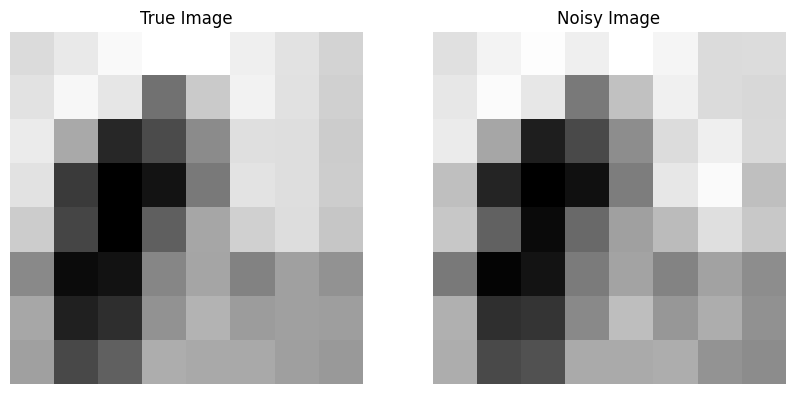

In [7]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [8]:
model = TVRegularized(true, noisy, epsilon=0.0)

In [9]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-1,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      932
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      177
                     variables with only lower bounds:       65
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      176
Total number of inequality c

In [10]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

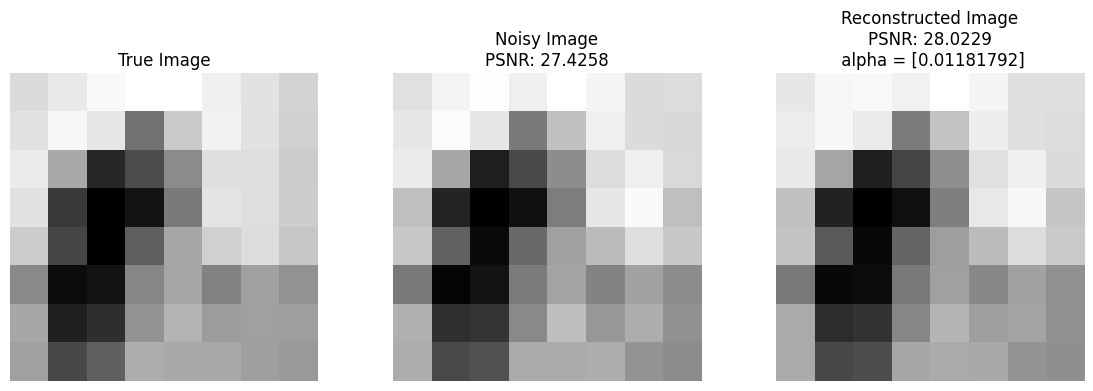

In [11]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [12]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [13]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [14]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 8.92255779e-01  9.54341785e-01  9.61763983e-01  9.30378176e-01
  9.84821766e-01  9.45073466e-01  8.63983231e-01  8.63937258e-01
  9.11266059e-01  9.53540690e-01  9.05968315e-01  4.94752993e-01
  7.62361520e-01  9.19683254e-01  8.63953756e-01  8.52639585e-01
  9.02976846e-01  6.48483667e-01  1.54044931e-01  2.89621943e-01
  5.63275273e-01  8.67021771e-01  9.23307106e-01  8.51040438e-01
  7.48919528e-01  1.63618880e-01  3.58109194e-02  9.66257456e-02
  5.04171440e-01  8.97083344e-01  9.54229281e-01  7.67436086e-01
  7.59665169e-01  3.71389625e-01  6.72478344e-02  4.07447695e-01
  6.24733468e-01  7.35025054e-01  8.51777518e-01  7.84717815e-01
  4.91384013e-01  6.87896696e-02  8.31711573e-02  4.89005374e-01
  6.32004891e-01  5.41199977e-01  6.36571422e-01  5.72825782e-01
  6.69179537e-01  1.99419957e-01  2.23593838e-01  5.32759036e-01
  7.10029115e-01  6.23177337e-01  6.46192402e-01  5.75661677e-01
  6.68841098e-01  3.04804248e-01  3.22059803e-01  6.56572045e-01
  6.72647439e-01  6.62504

In [19]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=0.0)

In [23]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=100,tol=1e-1,print_level=0,verbose=True,beta=0.7)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  0.0208856849702278      2.1952670886904375                 1.0

Restoration phase in the restoration phase failed.

Number of Iterations....: 447

                                   (scaled)                 (unscaled)
Objective...............:   7.3802999258585800e-02    7.3802999258585800e-02
Dual infeasibility......:   7.6142093026796809e-02    7.6142093026796809e-02
Constraint violation....:   8.1016152120305662e-11    8.1016152120305662e-11
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.0000000000000008e-11    5.0000000000000008e-11
Overall NLP error.......:   7.6142093026796809e-02    7.6142093026796809e-02


Number of objective function evaluations             = 903
Number of objective gradient evaluations             = 415
Number of equality constraint evaluations            = 903
Number of inequality constraint evaluations          = 903
Number of equality constraint Jacobian evaluations   = 450
Number of inequality constraint Jacobian evaluations = 450
Number of Lagrangian Hessian

1                 0  0.020885684926974252    2.1952624732556663                 0.7

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.1540040e-02 6.81e-02 1.18e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

2                 0  0.02088568600838989     2.1326855355911585      0.48999999999999994

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6051502e-02 3.40e-02 1.16e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

3                 0  0.02088568454948467     1.8888262469200257      0.3429999999999999

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8025384e-02 1.53e-02 1.21e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

4                 0  0.020885684847907933    1.4970519349760638      0.24009999999999992

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.8025384e-02 1.41e-02 1.21e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

5                 0  0.0208856850868809      1.121260159085687       0.16806999999999994

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0513801e-01 1.00e-02 1.22e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

6                 0  0.020885685348227104    0.8053705140771574      0.11764899999999995

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3549938e-01 1.00e-02 1.20e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

7                 0  0.020996322876628004    0.575753700394221       0.08235429999999996

Complementarity.........:   1.0000000005159364e-11    1.0000000005159364e-11
Overall NLP error.......:   5.9935383699998771e-09    5.9935383699998771e-09


Number of objective function evaluations             = 106
Number of objective gradient evaluations             = 84
Number of equality constraint evaluations            = 106
Number of inequality constraint evaluations          = 106
Number of equality constraint Jacobian evaluations   = 84
Number of inequality constraint Jacobian evaluations = 84
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 1.438

EXIT: Optimal Solution Found.
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
               

8                 0  0.02181711684600641     0.49861447624398075     0.05764800999999997

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8952048e-01 9.93e-03 1.18e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

9                 0  0.02282799367291003     0.38918683682545907     0.04035360699999998

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0500383e-01 9.91e-03 1.17e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

10                 0  0.024418708406319645    0.3130302595164517      0.028247524899999984

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1289708e-01 9.91e-03 1.17e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

11                 0  0.026477407440914227    0.21922363522781285     0.019773267429999988

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     4576
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1457
                     variables with only lower bounds:      737
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1216
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      480
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1671729e-01 9.88e-03 1.16e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

12                 0  0.029292963796476584    0.16223585722908168     0.01384128720099999

13                 0  0.0323670115917011      0.13163568089199248     0.009688901040699992

14                 0  0.03531788666264891     0.1067951048685356      0.006782230728489994

15*                0  0.03786059359185827     0.08799400715067135     0.004747561509942996

In [24]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

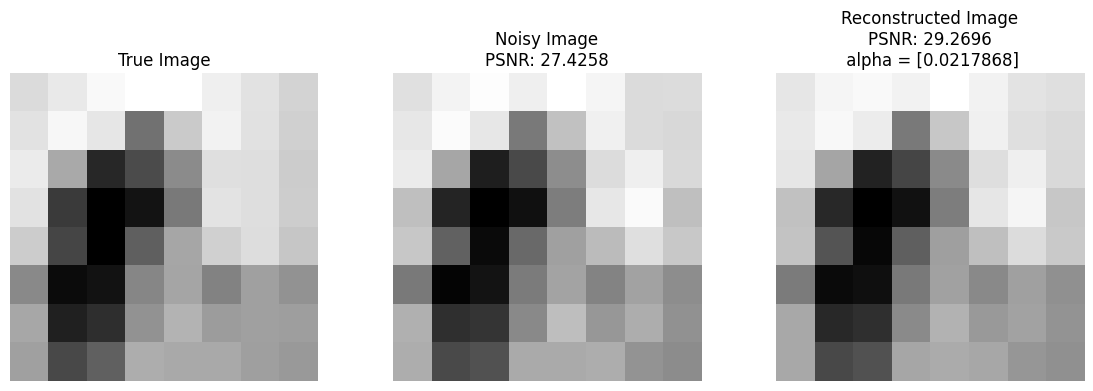

In [25]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)